# What makes neurons picky?
## Tom George, April 2020

## Introduction
Neurons in different regions of the brain do not all behave the same. Take the difference between the visual cortex and the prefrontal cortex; in the visual cortex neurons respond highly selectively to  specific visual stimuli ranging from oriented lines and edges in the V1 to complex shapes, textures and faces in deeper layers. If a neuron is known to respond (i.e. fire above baseline) when a face is present in a visual scene it will probably respond only weakly, or not at all, when the subject is shown, for example, an apple, or a dog. Neurons are specifically tuned to pick out one thing and one thing only. Conversely, neurons in the prefrontal cortex (the area of the brain known to be involved in decision making and planning complex cognitive behaviours) show incredibly complex response patterns. Their firing rates have been shown to contain information about a broad range of task-relevant stimuli. To put this in the context a neuron in the PFC may be important when you are trying to remember a phone number which has just been read to you, but it is likely this is also important in many other very different cognitive tasks, e.g. planning when to cross a road.

But what causes this? Why are neurons 'mixed selective' in the PFC but 'selective' in the visual cortex. Both brain regions perform their function well but are subject to different constraints. First and foremost, the space of all possible cognitive tasks the PFC might be required to perofrm is practically infinite (complex tasks can be composed recursively from simpler tasks) whereas visual scenes (although rich and varied) are generally built from a basic set of polygons, colours and textures. Rigotti et al (2013) show that mixed selectivity offers a significant computational advantage over selectivity by vastly increasing the repertoir of potential input-output functions. Perhaps neurons are, by default, mixed selective, but when a task is repeatedly performed very very often it becomes more efficient to dedicate a neuron (or more likely a subset of neurons) to performing just that task (just as we might dedicate a folder on our hardrive to storing only college work, or a room in our house to cooking) - perhaps, then, the visual cortex contains selective neurons because tasks such as recognising faces, emotions, family members or food types are performed regularly. This argument can be extended to a higher level, perhap highly specialised brain regions (the visual cortex, the motor cortex, the olfactory cortex etc.) developed throughout evolution because otherwise more-generalised computing regions in the brain (for example the PFC) were becoming overwhelmed by having to repeatedly perform the same tasks over-and-over again. 

In this project I want to explore and test these hypotheses from a computational perspective. To do this we will build a deep neural network (representing a general but simple function approximator which we can probe) and train it on multiple tasks, simultaneously. We can then analyse the hidden neurons (which represent the neurons in the PFC or the visual cortex which 'do' the computation which leads to our concious percepts or behaviour) to see whether they are mixed-selective or selective and discuss test what affects this. It's not meant to be a detailed biologically plausible replica of any single brain area but rather the simplest model from which we can probe neuronal selectivity and the parameters which effect this. 

## Simple model trained on simple tasks
To start we will train a very simple model on very simple tasks. For this purpose we will build a vanilla deep neural network with just two input neurons and one output neuron. The purpose is to learn, simultanously, to add and multiply the two inputs. Along with the numerical inputs  we pass a task-context input; this is a one-hot vector ([1,0] for task 1 and [0,1] for task 2) informing the network which task to perform on a given run. The model has four hidden layers and is trained by batch back propagation. It is also (until we change this later on) heavily over parameterised with 100 hidden units in each layer. 

• Task 1: $x_0 + x_1$

• Task 2: $x_0 \cdot x_1$

The model class $\texttt{simple_network}$ in $\texttt{networks.py}$ does this. It is initialised with a list of mostly self-explanatory hyperparameters.



In [1]:
import numpy as np
np.seterr(all='ignore')
from networks import simple_network, MNIST_network
from utils import plot_training, plot_FTV, plot_lesion_test, train_multiple
simple_hyperparameters = {'N_train' : 1000, #size of training dataset 
                          'N_test' : 100, #size of test set x
                          'lr' : 0.001, #SGD learning rate 
                          'epochs' : 10, #training epochs
                          'batch_size' : 10,  #batch size (large will probably fail)           
                          'context_location' : 'start',  #where the feed in the task context 'start' vs 'end'
                          'train_mode' : 'random', #training mode 'random' vs 'replay' 
                          'second_task' : 'prod', #first task adds x+y, second task 'prod' = xy or 'add1.5' = x+1.5y
                          'fraction' : 0.50, #fraction of training data for tasks 1 vs task 2
                          'hidden_size' : 50} #hidden layer width

simple_model = simple_network(simple_hyperparameters)

Now train the model and plot the training accuracy on both tasks throughout training. In fact the analysis is better if we train a large number of models and plot the average result. A model is saved if and only if the error on both tasks is less than some threshold (0.05) after training.  

Training 100 models


100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


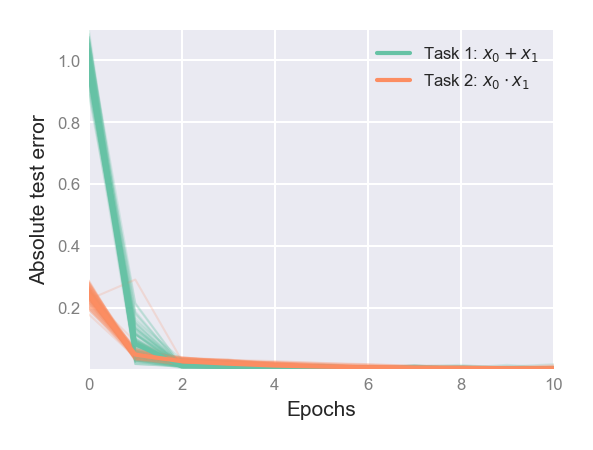

In [2]:
N_models = 100
models1 = train_multiple(simple_network, simple_hyperparameters, N_models = N_models)
plot_training(models1)

We now have multiple trained models which can perform both of the two tasks. But how do we know the selectivity preferences of the hidden neurons?  For this we define the 'importance', $\mathcal{I}_i(A)$, of neuron $i$ on task A. Intuitively we will define this as the squared change in the expected loss function (over task A's test set) when the hidden neurons are set to zero:
\begin{equation}
\mathcal{I}_i(A) = \mathop{\mathbb{E}}_{z\sim\mathcal{D_{A}}}\big[   (\ell(z;\mathbf{h}) - \ell(z;\mathbf{h}|h_{i}=0))^2 \big]
\end{equation}
Here $\mathbf{h}$ represents a vector containing the state of all hidden neurons in the network, and $\mathbf{h}_{h_{i}=0}$ represents the same network where $h_i$ is set to zero and then the effect of this is propagated forwards. We can Taylor expand the loss function about $\mathbf{h}$:
\begin{equation}
\ell(z;\mathbf{h}|h_{i}=0)  = \ell(z;\mathbf{h}) + (\mathbf{h}_{h_{i}=0} - \mathbf{h})^{\mathsf{T}}\frac{\partial \ell}{\partial \mathbf{h}} + \frac{1}{2} (\mathbf{h}_{h_{i}=0} - \mathbf{h})^{\mathsf{T}} \mathsf{H} (\mathbf{h}_{h_{i}=0} - \mathbf{h}) + ...
\end{equation}
To first order, therefore, the importance of a neuron is given by: 
\begin{equation}
\mathcal{I}_i(A) \approx \mathop{\mathbb{E}}_{z\sim\mathcal{D_{A}}}\bigg[ \bigg(h_i \cdot \frac{\partial \ell}{\partial h_i}\bigg)^2 \bigg]
\end{equation}
which is fairly trivially computed using a pytorch framework by computing the $\texttt{.grad()}$ function on the hidden layers.

To study whether a neuron is selective to one task or mixed selvtive we will define the 'relative importance', $\mathcal{RI}_i(A,B)$, of neuron $i$ over tasks $A$ and $B$:
\begin{equation}
\mathcal{RI}_i(A,B) = \frac{\mathcal{I}_i(A) - \mathcal{I}_i(B)}{\mathcal{I}_i(A)+ \mathcal{I}_i(B)}
\end{equation}
If the relative importance is close to 1 then we can assume the neuron is entirely selective to task A and unimportant for task B - vica versa if $\mathcal{RI}_i(A,B)$ is close to -1. IF $\mathcal{RI}_i(A,B) \approx 0$ then the neuron is equally important to both the tasks. By plotting a histogram over all the neurons in a hidden layer (and over many identically trained but independently initialised models) we can get a broad picture of how the computational effort requireed to solve the two tasks is shared amongst the neurons. The function $\texttt{plot_RI()}$ plots these relative importance histograms for neurons in all four hidden layers and across all models (the input and output layer are not shown).

## Simple Network Experiments
### 1/6 Standard Experiment

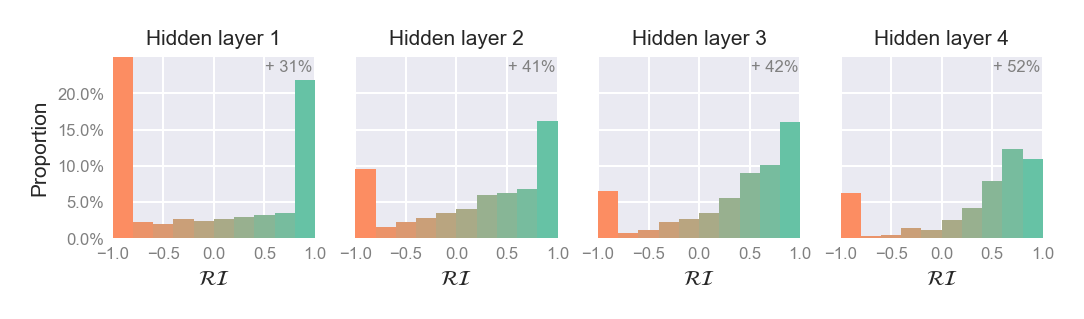

In [3]:
plot_RI(models1)

![title](Figures/exp1.png)

On the x-axis of each plot is the relative importance. On the y-axis is the proportion of neurons with that corresponding $\mathcal{RI}$. The colour smoothly changes from green on the right (representing neurons which are mostly important for task 1 but not task 2) to orange on the left (representing neurons which are mostly important for task 2 but not task 1). The percentage in the top right corner shows the proportion of neuorns which are not important for either task 1 or or task 2 and so do no show in the histogram.

In the first layer the FTV is strongly bimodal. Most neurons are either exclusively important for task 1 or for task 2 and relatively few neurons are mixed. This trend continues throughout the network, essentially two almost independent subnetworks have been built solve the two tasks a is shown schematically in the figure beneath the plots. 


### 2/6 Similar vs different tasks 
Now let try a different second task. Finding the proudct of two number is contextually quite different to finding their sum. But what if we mae the second task also an addition, like task 1, but instead of $x_0 + x_1$ task 2 is to find $x_0 + 1.5x_1$). Will this make a significant differnence?

Training 100 models


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


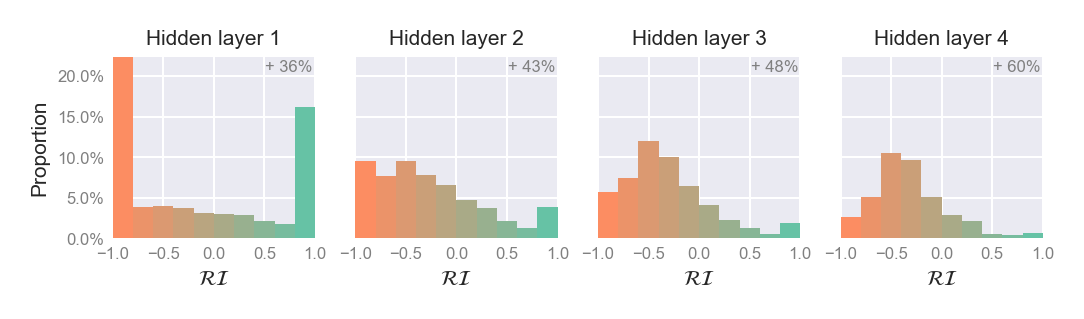

In [4]:
simple_hyperparameters['second_task'] = 'add1.5'
models2 = train_multiple(simple_network, simple_hyperparameters, N_models = N_models)
plot_RI(models2)

![title](Figures/exp2.png)

In fact, the answer is yes - it does make a huge difference. When the second task is made to be bery similar to the first task the neurons downstream from the first hidden layer learn very mixed selective representations (shown by the unimodal 'hump' in the middle of the histogram. THis is quite interesting, particularly as the difference is so stark compared to before, when the second task was to find the product of the two numbers. 
The difference is stark: now the bimodality in the initial layer is rapidly lost as we go deeper into the network and the $\mathcal{RI}$ disstribution becomes unimodal. What we can conclude here is that the network effectively 'learns' that the two task it is meant to perform are effectively the same and so shares computational effort amongst the neurons.

### 3/6 Constraining the network
One logical assumption we might test is that, if the network is mde to be very small, this encourages the neurons to share the computation for both tasks. In other words, there simply isn't enough capacity to learn two independent subnetworks (one for each tasks) and the neurons are forced to be mixed selective. To test this we will decrease the size of the hidden layer from 100 to 5. 

Training 100 models


100%|██████████| 100/100 [03:49<00:00,  2.29s/it]


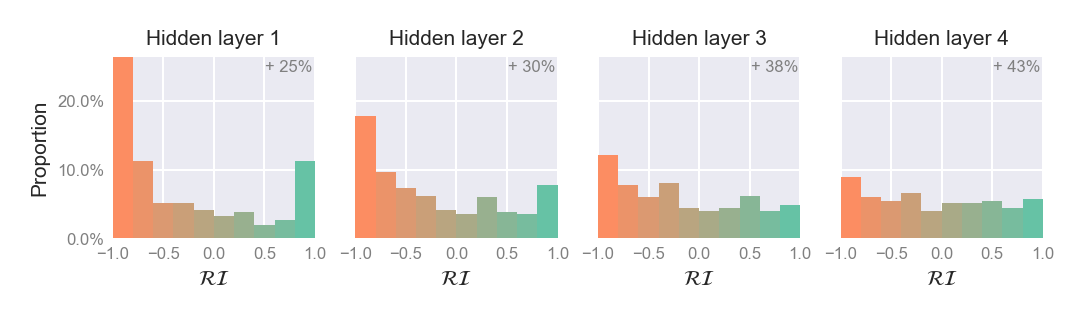

In [5]:
simple_hyperparameters['second_task'] = 'prod'
simple_hyperparameters['hidden_size'] = 5
models3 = train_multiple(simple_network, simple_hyperparameters, N_models = N_models)
plot_RI(models3)

![title](Figures/exp3.png)

Our intuitions have been confirmedand neurons are now, mostly, mixed selctive in hidden layers after the first. It appears network capacity is an import factor in determining how tasks are solved. This raises an important point which is regularly overlooked when neural networks are being designed: the capacity of the neural network not only determines whether the task(s) in question will be solved but it can affect how that task is learn - a heavily overparametrised neural network may be more inclined to learn two tasks independently without realising their shared structure.   

### 4/6 Context location
Where we feed in the 'which task' information may matter. There is certainly a lot of discussion in the neuroscience community about task context information and how this is handled. A dominant theory is that the PFC acts as a 'context cortex' (see Cohen et al) sending signals to the primary sensory cortices telling them which information to concentrate on and which to ignore (we can ignore the colour of the sky when crossing a road, for example). What will happen in our simple network if we only pass teh context vector in at the penultimate layer. 

Training 100 models


100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


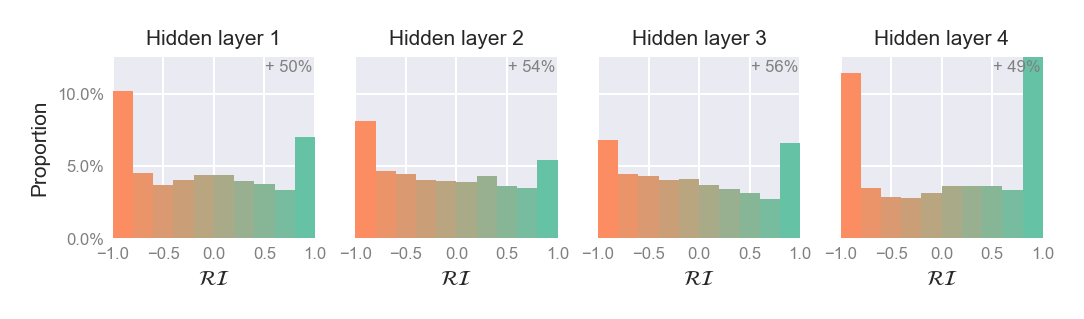

In [6]:
simple_hyperparameters['hidden_size'] = 100
simple_hyperparameters['context_location'] = 'end'
models4 = train_multiple(simple_network, simple_hyperparameters, N_models = N_models)
plot_RI(models4)


![title](Figures/exp4.png)

The initial alyers are largely mixed selective whilst the final hidden layer (layer 4, just after where the context has been added) is strongly selective. This is similar to what we observed in the standard experiment whereby the context vector acts sos as to split the network into two non-ioverlapping subnetworksd.

What is most interesting here is that context information can flow backwards, as seen by a surplus of neurons in early hidden layers which are entirely selective to just task 1 or task 2. Even though 'which task' information is never given until layer 4 neurons in layers 1, 2 and 3 learn to specialise to one task or the other, this is the power of backpropagation which can pass task-relevant information back into earlier layers by means of the gradient of the loss. This finding has some interesting consequences: it is commonly believed in mac'hine learning that early layers act as 'feature extractors' whilst later layers regress or classify these features. This may still be the case but the above finding suggests that these 'feature extractors' need not be task independent and can be specialised even if the context if not given until after further downstream. This may have some implications for transfer learning and convolutional techniques.


### 5/6 Training style: Random vs Sequential

Up until now training has been random and the network takes a random selection of both tasks at each batch, but this is not how people learn. Usually people learn things in chunks, this tyoe of learning is called continual learning or sequential learning. In continual learning we train entirely on one task and then, afterwards, train entirely on a different task. OFten in machine learning this second phase results in 'catastrophic forgetting' of the first task and to avoid this there are a number of remedies. here we will use a simple 'replay technique' where during the second phase of training on task 2 every 10 iterations (or strictly speaking batches) we train once on the orignial task so as not to forget it.

Training 100 models


100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


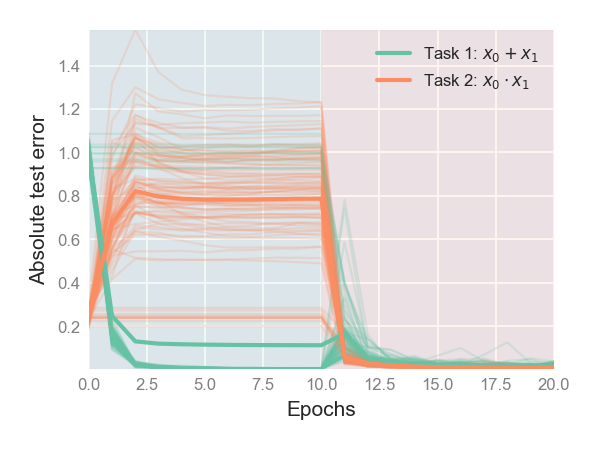

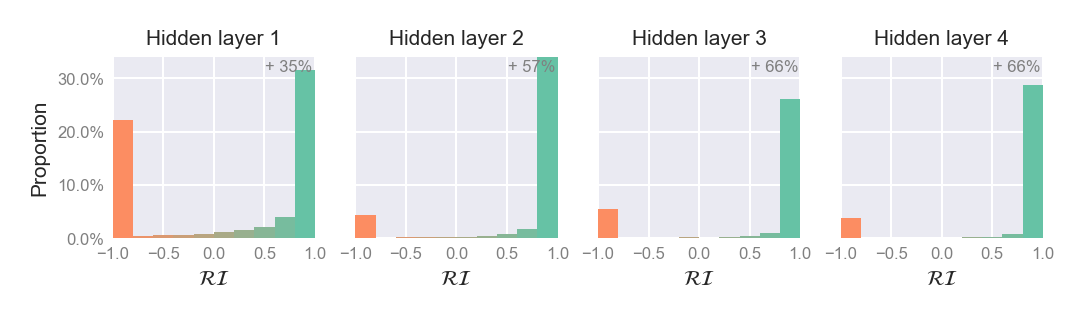

In [7]:
simple_hyperparameters['context_location'] = 'start' 
simple_hyperparameters['train_mode'] = 'replay'
models5 = train_multiple(simple_network, simple_hyperparameters, N_models = N_models)
plot_training(models5)
plot_RI(models5)

In the training plot the shading represents what task is being treined at that current point. The result seems to suggest that continual learning encourages neurons to learn selective representations of tasks. Perhaps this is explainable because, whilst training the first task the weights abd biases fall into a deep local optima for the first tasks which (thanks to the replay during phase 2) they do not escape. Task 2 can only then be solved by an entirely different set of neurons which is not part of the optimal subset used to solve task 1.

### 6/6 Training bias 
So far we have trained equally on task 1 and task 2, but what is we strongly bias towards one or the other? We discussed how it is logical that this might encourage selectivity but is this in fact the case? We can now check by simply repeating training but biasing the train dataset towards one of the tasks. We will set the second task to be 'add1.5' so that the default performance is mixed selective. The bias fraction is controlled by the hyperparameter 'fraction'.

Training 100 models


100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


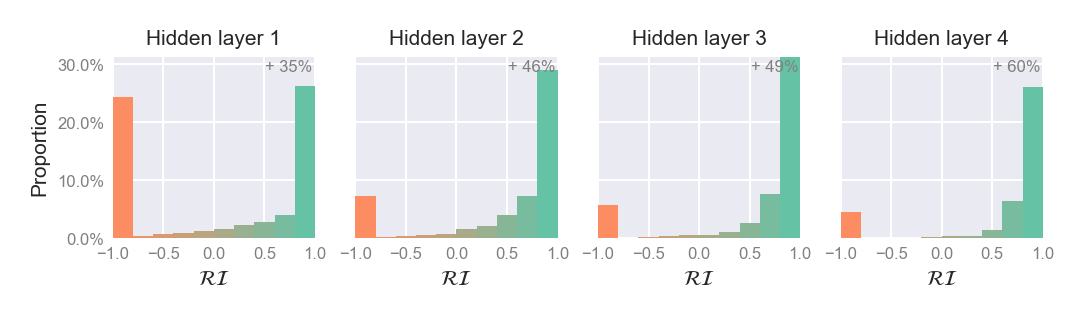

In [8]:
simple_hyperparameters['train_mode'] = 'random'
simple_hyperparameters['fraction'] = 0.2
models6 = train_multiple(simple_network, simple_hyperparameters, N_models = N_models)
plot_RI(models6)

In the training plot the shading represents what task is being treined at that current point. As you can see 